In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
from diffSPH.v2.sampling import samplePDF

def pdf(x):
    return 2 + np.sin(2*np.pi*x)


In [3]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
        'dim': 1,
        'periodic': True
    },
    'particle': {
        'nx': 2**10
    },
    'kernel':{
        'name': 'Wendland2'
    },
    "neighborhood":{
        "scheme": "small"
    },
    'EOS':{
        'type': 'Tait',
        'kappa': 1.5
    }
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

particles = samplePDF(pdf, plot = True, n = 2*config['particle']['nx'], numParticles = config['particle']['nx'])

{'domain': {'minExtent': tensor([-1.]),
  'maxExtent': tensor([1.]),
  'dim': 1,
  'periodic': True,
  'periodicity': tensor([True])},
 'particle': {'nx': 65536,
  'dx': tensor(3.0518e-05),
  'support': tensor(9.8888e-05),
  'defaultVolume': tensor(3.0518e-05),
  'defaultSupport': tensor(9.8888e-05),
  'volume': tensor(3.0518e-05),
  'smoothingLength': tensor(6.1035e-05)},
 'kernel': {'name': 'Wendland2',
  'targetNeighbors': tensor(6.4807),
  'function': <diffSPH.kernels.KernelWrapper at 0x77474a41f850>,
  'kernelScale': tensor(1.6202)},
 'neighborhood': {'scheme': 'small', 'verletScale': 1.5},
 'EOS': {'type': 'Tait',
  'kappa': 1.5,
  'gasConstant': 8.14,
  'molarMass': 0.02897,
  'polytropicExponent': 7},
 'compute': {'device': 'cpu', 'precision': 'float32', 'dtype': torch.float32},
 'simulation': {'correctArea': False,
  'supportScheme': 'symmetric',
  'densityScheme': 'continuity',
  'timestamp': '2024_06_04-12_56_19'},
 'fluid': {'rho0': 1000, 'mu': 0.1, 'cs': 10},
 'plot': {'mo

In [4]:
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.sphOps import sphOperation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.sphOps import sphOperationStates

def resampleToGrid1D(simulationState, inQuantity, config, nGrid = 127):
    dx = (config['domain']['maxExtent'][0] - config['domain']['minExtent'][0]) / nGrid    
    x = torch.linspace(config['domain']['minExtent'][0] + dx/2, config['domain']['maxExtent'][0] - dx/2, nGrid).view(-1,1)
    dim = x.shape[1]
    vol = dx ** dim

    targetNeighbors = config['kernel']['targetNeighbors']
    support = volumeToSupport(vol, targetNeighbors, dim)
    xarea = torch.ones(x.shape[0]) * vol
    hx = torch.ones(x.shape[0]) * support

    i, j, rij, xij, hij, kernel, gradKernel = neighborSearch(
        x, simulationState['fluid']['positions'], hx, simulationState['fluidSupports'], 
        config['kernel']['function'], config['domain']['dim'],
        config['domain']['periodicity'].detach().cpu().numpy().tolist() , config['domain']['minExtent'], config['domain']['maxExtent'], mode = 'symmetric')
    # kernel = config['kernel']['function'].kernel(rij, hij, dim)
    # gradKernel = config['kernel']['function'].kernelGradient(rij, xij, hij, dim)

    rho = sphOperation((None, simulationState['fluidMasses']), (None, simulationState['fluidDensities']), (None, inQuantity), (i, j), kernel, gradKernel, 
                    rij, xij, hij, x.shape[0],operation = 'interpolate', gradientMode = 'difference')
    
    return x, rho

def scatterPlot(fig, axis, simulationState, c, label = None, cmap = 'viridis'):
    sc = axis.plot(simulationState['fluidPositions'][:,0], c)#, lw = 2, marker = 'x', markersize = 2, linestyle = '-')
    ax1_divider = make_axes_locatable(axis)
    # cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    # cb = fig.colorbar(sc, cax=cax1,orientation='vertical')
    if label is not None:
        axis.set_title(label)
    # if p.shape[1] > 1:
        # square = patches.Rectangle((domainMin[0], domainMin[1]), domainMax[0] - domainMin[0], domainMax[1] - domainMin[1], linewidth=1, edgecolor='b', facecolor='none',ls='--')
        # axis.add_patch(square)
    # axis.set_aspect('equal')
    # axis.set_xlim(-1.05,1.05)
    # axis.set_ylim(-1.05,1.05)

In [5]:


perennialState = {'fluid':{}}

area = 2 / config['particle']['nx']
perennialState['fluid']['positions'] = particles
perennialState['fluid']['areas'] = particles.new_ones(particles.shape[0]) * 2 * area
perennialState['fluid']['masses'] = perennialState['fluid']['areas'] * config['fluid']['rho0']
perennialState['fluid']['supports'] = volumeToSupport(area, config['kernel']['targetNeighbors'], config['domain']['dim'])
perennialState['fluid']['velocities'] = torch.zeros_like(particles)

perennialState['fluid']['numParticles'] = particles.shape[0]

perennialState['fluid']['neighborhood'] = neighborSearch(perennialState['fluid'], perennialState['fluid'], config)
perennialState['fluid']['densities'] = sphOperationStates(perennialState['fluid'], perennialState['fluid'], None, operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])
_, perennialState['fluid']['NumNeighbors'] = countUniqueEntries(perennialState['fluid']['neighborhood']['indices'][0], perennialState['fluid']['positions'])

initialState = copy.deepcopy(perennialState)

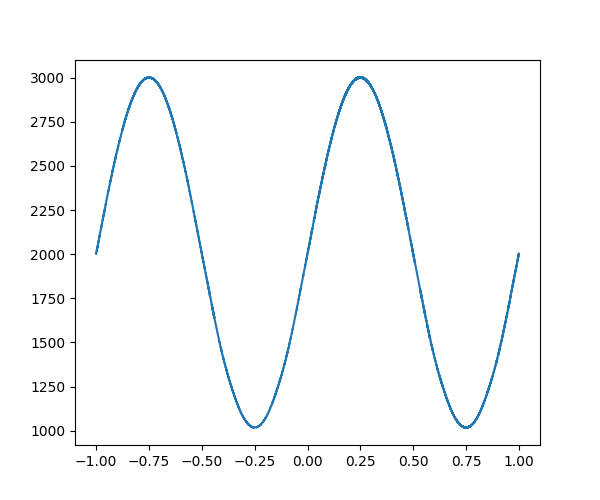

In [59]:

fig, axis = plt.subplots(1, 1, figsize = (6,5), squeeze = False)

# axis[0,0].scatter(particles[:,0], particles[:,0] * 0, s = 1)
axis[0,0].plot(perennialState['fluid']['positions'],perennialState ['fluid']['densities'])

In [7]:
import torch
from diffSPH.v2.math import scatter_sum
from typing import Dict, Optional, Union
from torch.profiler import record_function

@torch.jit.script 
def sphInterpolation(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    k = masses[1][j] / densities[1][j] * kernels
    kq = torch.einsum('n..., n -> n...', quantities[1][j] if isinstance(quantities,tuple) else quantities, k)
    
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)

@torch.jit.script 
def sphDensityInterpolation(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    kq = masses[1][j] * kernels
    
    return scatter_sum(kq, neighborhood[0], dim = 0, dim_size = numParticles)


@torch.jit.script 
def sphGradient(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]
    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric gradient only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        kq = torch.einsum('n... , nd -> n...d', Ai + Aj, k)

        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
    elif type == 'difference':
        k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
        qij = (quantities[0][i] - quantities[1][j]) if isinstance(quantities, tuple) else quantities
        kq = torch.einsum('n... , nd -> n...d', qij, k)
    elif type == 'summation':
        k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
        qij = (quantities[0][i] + quantities[1][j]) if isinstance(quantities, tuple) else quantities
        kq = torch.einsum('n... , nd -> n...d', qij, k)
    else:
        k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
        qij = (quantities[1][j]) if isinstance(quantities, tuple) else quantities
        kq = torch.einsum('n... , nd -> n...d', qij, k)
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


@torch.jit.script 
def sphDivergence(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive', mode : str = 'div'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    assert (isinstance(quantities, tuple) and quantities[0].dim() > 1) or (isinstance(quantities, torch.Tensor) and quantities.dim() > 1), 'Cannot compute divergence on non vector fields!'
    assert (mode in ['div','dot']), 'Only supports div F and nabla dot F'

    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric divergence only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        q = Ai + Aj
            
        if mode == 'div':
            kq = torch.einsum('n...d, nd -> n...', q, k)
        else:
            kq = torch.einsum('nd..., nd -> n...', q, k)

        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
        
    q = quantities[1][j] if isinstance(quantities, tuple) else quantities
    k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
    
    if type == 'difference':
        q = (quantities[1][j] - quantities[0][i]) if isinstance(quantities, tuple) else quantities
    elif type == 'summation':
        q = (quantities[1][j] + quantities[0][i]) if isinstance(quantities, tuple) else quantities
        
    if mode == 'div':
        kq = torch.einsum('n...d, nd -> n...', q, k)
    else:
        kq = torch.einsum('nd..., nd -> n...', q, k)
            
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


@torch.jit.script 
def sphCurl(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int, type : str = 'naive'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    assert (isinstance(quantities, tuple) and quantities[0].dim() > 1), 'Cannot compute curl on non vector fields!'
    assert gradKernels.shape[1] > 1, 'Cannot compute curl on one-dimensional fields!'

    if type == 'symmetric':
        assert isinstance(quantities, tuple), 'Symmetric curl only supports two inputs for quantities!'
        k = masses[1][j].view(-1,1) * gradKernels
        Ai = torch.einsum('n..., n -> n...', quantities[0][i], 1.0 / densities[0][i]**2)
        Aj = torch.einsum('n..., n -> n...', quantities[1][j], 1.0 / densities[1][j]**2)
        q = Ai + Aj
            
        if quantities[1].dim() == 2:
            kq = q[:,1] * k[:,0] - q[:,0] * k[:,1]
        else:
            kq = torch.cross(q, k, dim = -1)        
        
        return torch.einsum('n, n... -> n...', densities[0], scatter_sum(kq, i, dim = 0, dim_size = numParticles))
        
    q = (quantities[1][j])
    k = (masses[1][j] / densities[1][j]).view(-1,1) * gradKernels
    
    if type == 'difference':
        q = (quantities[1][j] - quantities[0][i]) if isinstance(quantities, tuple) else quantities
    elif type == 'summation':
        q = (quantities[1][j] + quantities[0][i]) if isinstance(quantities, tuple) else quantities
        
    if q.dim() == 2:
        kq = q[:,1] * k[:,0] - q[:,0] * k[:,1]
    else:
        kq = torch.cross(q, k, dim = -1)            
    
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


@torch.jit.script 
def sphLaplacian(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], gradKernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        laplaceKernels : Optional[torch.Tensor],    
        rij: torch.Tensor, xij:  torch.Tensor, hij : torch.Tensor,
        numParticles : int, type : str = 'naive'):    # Ancillary information
    i = neighborhood[0]                                                    
    j = neighborhood[1]

    if (isinstance(quantities, tuple) and quantities[0].dim() > 2) or (not isinstance(quantities, tuple) and quantities.dim() > 2):
        grad = sphGradient(masses, densities, quantities, neighborhood, gradKernels, numParticles, type = 'difference')
        div = sphDivergence(masses, densities, (grad, grad), neighborhood, gradKernels, numParticles, type = 'difference', mode = 'div')
        return div
    if type == 'naive':     
        assert laplaceKernels is not None, 'Laplace Kernel Values required for naive sph Laplacian operation'
        if laplaceKernels is not None:   
            print('naive')
            lk = -(masses[1][j] / densities[1][j]) * laplaceKernels
            qij = (quantities[0][i] - quantities[1][j]) if isinstance(quantities, tuple) else quantities
            kq = torch.einsum('n, n... -> n...', lk, qij)
            # kq = torch.einsum('n, n... -> n...', lk, quantities[1][j])
        
            return scatter_sum(kq, i, dim = 0, dim_size = numParticles)
            
    quotient = (rij * hij + 1e-7 * hij)
    kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
    kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij
    
    Aij = (quantities[0][i] - quantities[1][j]) if isinstance(quantities, tuple) else quantities
    if Aij.dim() == 1:
        kq = -Aij * (masses[1][j] / densities[1][j]) * 2 * kernelApproximation
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)
    
    if type == 'conserving':
        dot = torch.einsum('nd, nd -> n', Aij, xij) 
        q = (masses[1][j] / densities[1][j]) * kernelApproximation * dot# * rij
        kq = -q.view(-1, 1) * xij 
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)
        
    if type == 'divergenceFree':
        dot = torch.einsum('nd, nd -> n', Aij, xij) / (rij * hij + 1e-7 * hij)
        q = 2 * (xij.shape[1] + 2) *  (masses[1][j] / densities[1][j]) * dot
        kq = q.view(-1, 1) * gradKernels
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)

    if type == 'dot':
        term = -(xij.shape[1] + 2) * torch.einsum('nd, nd -> n', Aij, xij).view(-1,1) * xij - Aij
        kq = term * (masses[1][j] / densities[1][j] * kernelApproximation).view(-1,1)
        return scatter_sum(kq, i, dim = 0, dim_size = numParticles)

    q = -2 * (masses[1][j] / densities[1][j]) * kernelApproximation
    kq = Aij * q.view(-1,1)
    return scatter_sum(kq, i, dim = 0, dim_size = numParticles)


@torch.jit.script
def sphOperation(
        masses : tuple[torch.Tensor, torch.Tensor],                                                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                                                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor, kernelGradients : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels and kernelGradients ij
        radialDistances : torch.Tensor, directions : torch.Tensor, supports : torch.Tensor,                         # Graph information of |x_j - x_i| / hij, (x_j - x_i) / |x_j - x_i| and hij
        numParticles : int,                                                                                         # Ancillary information
        operation : str = 'interpolate', gradientMode : str = 'symmetric', divergenceMode : str = 'div',
        kernelLaplacians : Optional[torch.Tensor] = None):           # Operation to perform
    with record_function("[SPH] - Operation [%s]" % operation):
        if operation == 'density':
            return sphDensityInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
        if operation == 'interpolate':
            return sphInterpolation(masses, densities, quantities, neighborhood, kernels, numParticles)
        if operation == 'gradient':
            return sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
        if operation == 'divergence':
            return sphDivergence(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)
        if operation == 'curl':
            return sphCurl(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
        if operation == 'laplacian':
            return sphLaplacian(masses, densities, quantities, neighborhood, kernelGradients, kernelLaplacians, radialDistances, directions, supports, numParticles, type = gradientMode)
        if operation == 'directLaplacian':
            grad = sphGradient(masses, densities, quantities, neighborhood, kernelGradients, numParticles, type = gradientMode)
            div = sphDivergence(masses, densities, (grad, grad), neighborhood, kernelGradients, numParticles, type = gradientMode, mode = divergenceMode)
            return div
    
    
def sphOperationStates(stateA, stateB, quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]], neighborhood: dict, operation : str = 'interpolate', gradientMode : str = 'symmetric', divergenceMode : str = 'div'):
    if operation == 'density':
        return sphDensityInterpolation(
            (stateA['masses'], stateB['masses']), 
            (stateA['masses'], stateB['masses']),
            (stateA['masses'], stateB['masses']), 
            neighborhood['indices'], 
            neighborhood['kernels'], 
            stateA['numParticles'])
    return sphOperation(
        (stateA['masses'], stateB['masses']), 
        (stateA['densities'], stateB['densities']),
        quantities, 
        neighborhood['indices'], 
        neighborhood['kernels'], neighborhood['gradients'], 
        neighborhood['distances'], neighborhood['vectors'], neighborhood['supports'], 
        stateA['numParticles'], 
        operation = operation, gradientMode = gradientMode, divergenceMode = divergenceMode, 
        kernelLaplacians = neighborhood['laplacians'] if 'laplacians' in neighborhood else None)

In [8]:
particles.shape

torch.Size([65536, 1])

In [9]:
from diffSPH.v2.compiler import compileSourceFiles

In [15]:
sphOperation_cpp = compileSourceFiles(
    ['/home/winchenbach/dev/diffSPH/partiBench/cppOp.cpp', '/home/winchenbach/dev/diffSPH/partiBench/cppOp.cu'], module_name = 'sphOperations', verbose = False, openMP = True, verboseCuda = False, cuda_arch = None)
# from torch.utils.cpp_extension import load

# sphOperation_cpp = load(name='sphOperations', sources=['/home/winchenbach/dev/diffSPH/partiBench/cppOp.cpp'], verbose = True, with_cuda = False, is_python_module = False, extra_cflags = ['-fopenmp'], extra_ldflags = ['-fopenmp'])
sphDensity_cpp = sphOperation_cpp.sphDensity
sphInterpolation_cpp = sphOperation_cpp.sphInterpolation

In [16]:
%%timeit

cppDensity = sphDensity_cpp(
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']),
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['neighborhood']['kernels'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['numNeighbors'],
    perennialState['fluid']['neighborhood']['neighborOffsets'],
)

277 µs ± 754 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
%%timeit

torchDensity = sphDensityInterpolation(
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']),
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['neighborhood']['kernels'], 
    perennialState['fluid']['numParticles']
)

# torchDensity = sphOperationStates(
#     perennialState['fluid'], perennialState['fluid'], None, 
#     operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])

3.54 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%%timeit

cppDensity = sphInterpolation_cpp(
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']),
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['neighborhood']['kernels'], 
    perennialState['fluid']['numParticles'],
    perennialState['fluid']['neighborhood']['numNeighbors'],
    perennialState['fluid']['neighborhood']['neighborOffsets'],
)

439 µs ± 782 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%%timeit

torchDensity = sphInterpolation(
    (perennialState['fluid']['masses'], perennialState['fluid']['masses']), 
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']),
    (perennialState['fluid']['densities'], perennialState['fluid']['densities']), 
    perennialState['fluid']['neighborhood']['indices'], 
    perennialState['fluid']['neighborhood']['kernels'], 
    perennialState['fluid']['numParticles']
)

# torchDensity = sphOperationStates(
#     perennialState['fluid'], perennialState['fluid'], None, 
#     operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])

7.53 ms ± 34.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
masses_device = perennialState['fluid']['masses'].to('cuda')
densities_device = perennialState['fluid']['densities'].to('cuda')
neighborhood_device = {key: (value.to('cuda') if isinstance(value, torch.Tensor) else value) for key, value in perennialState['fluid']['neighborhood'].items()}
neighborhood_device['indices'] = (neighborhood_device['indices'][0].to('cuda'), neighborhood_device['indices'][1].to('cuda'))
quantities_device = densities_device
numParticles_device = perennialState['fluid']['numParticles']


In [31]:
neighborhood_device['indices']

(tensor([    0,     0,     0,  ..., 65535, 65535, 65535], device='cuda:0'),
 tensor([    0,     1,     2,  ..., 65533, 65534, 65535], device='cuda:0'))

In [48]:
# @torch.jit.script
def broadcast_njit(src: torch.Tensor, other: torch.Tensor, dim: int):
    if dim < 0:
        dim = other.dim() + dim
    if src.dim() == 1:
        for _ in range(0, dim):
            src = src.unsqueeze(0)
    for _ in range(src.dim(), other.dim()):
        src = src.unsqueeze(-1)
    src = src.expand(other.size())
    return src

# @torch.jit.script
def scatter_sum_njit(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast_njit(index, src, dim)
    if out is None:
        size = list(src.size())
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)
    
# @torch.jit.script 
def sphInterpolation_njit(
        masses : tuple[torch.Tensor, torch.Tensor],                                 # Tuple of particle masses for (i,j)
        densities : tuple[torch.Tensor, torch.Tensor],                              # Tuple of particle densities for (i,j)
        quantities : Union[torch.Tensor, tuple[torch.Tensor, torch.Tensor]],                             # Tuple of particle quantities for (i,j)
        neighborhood : tuple[torch.Tensor, torch.Tensor], kernels : torch.Tensor,   # Neighborhood information (i,j) and precomupted kernels ij
        numParticles : int):                                                        # Ancillary information
    j = neighborhood[1]
    
    kq = torch.einsum('n..., n -> n...', quantities[1][j] if isinstance(quantities,tuple) else quantities, masses[1][j] / densities[1][j] * kernels)
    
    return scatter_sum_njit(kq, neighborhood[0], dim = 0, dim_size = numParticles)


compiled_interpolation = torch.compile(sphInterpolation_njit, dynamic=False)

compiled_interpolation(
    (masses_device, masses_device), 
    (densities_device, densities_device),
    (densities_device, densities_device), 
    neighborhood_device['indices'], 
    neighborhood_device['kernels'], 
    numParticles_device
)

tensor([2002.8176, 2002.8176, 2002.8462,  ..., 2002.8177, 2002.8176,
        2002.8176], device='cuda:0')

In [56]:
q = torch.randn(numParticles_device, 3,3,3,3,3).to('cuda')

In [57]:
%%timeit
torch.cuda.synchronize()
compiled_interpolation(
    (masses_device, masses_device), 
    (densities_device, densities_device),
    (q, q), 
    neighborhood_device['indices'], 
    neighborhood_device['kernels'], 
    numParticles_device
)
torch.cuda.synchronize()

1.85 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%%timeit
torch.cuda.synchronize()
torchDensity_device = sphInterpolation(
    (masses_device, masses_device), 
    (densities_device, densities_device),
    (q, q), 
    neighborhood_device['indices'], 
    neighborhood_device['kernels'], 
    numParticles_device
)
torch.cuda.synchronize()

3.91 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
%%timeit

torch.cuda.synchronize()
cppDensity_device = sphInterpolation_cpp(
    (masses_device, masses_device), 
    (densities_device, densities_device),
    (quantities_device, quantities_device), 
    neighborhood_device['indices'], 
    neighborhood_device['kernels'], 
    numParticles_device,
    neighborhood_device['numNeighbors'],
    neighborhood_device['neighborOffsets'],
)
torch.cuda.synchronize()

29.6 µs ± 262 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
perennialState['fluid']['densities'] = sphOperationStates(perennialState['fluid'], perennialState['fluid'], None, operation = 'density', neighborhood = perennialState['fluid']['neighborhood'])

In [8]:
q = perennialState['fluid']['densities']

b_scalar = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (q *0, q), operation = 'interpolate', neighborhood = perennialState['fluid']['neighborhood'])

b_grad = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (q *0, q), operation = 'gradient', neighborhood = perennialState['fluid']['neighborhood'], gradientMode = 'naive')

In [54]:
xij = -perennialState['fluid']['neighborhood']['vectors'] * perennialState['fluid']['neighborhood']['distances'].view(-1,1) * config['particle']['support']

In [55]:
M_0 = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (torch.ones_like(q), torch.ones_like(q)), operation = 'interpolate', neighborhood = perennialState['fluid']['neighborhood'])

M_grad = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (torch.ones_like(q), torch.ones_like(q)), operation = 'gradient', neighborhood = perennialState['fluid']['neighborhood'], gradientMode = 'naive')

M_x = sphOperationStates(perennialState['fluid'], perennialState['fluid'], xij, operation = 'interpolate', neighborhood = perennialState['fluid']['neighborhood'])
M_x_grad = sphOperationStates(perennialState['fluid'], perennialState['fluid'], xij, operation = 'gradient', neighborhood = perennialState['fluid']['neighborhood'], gradientMode = 'naive')

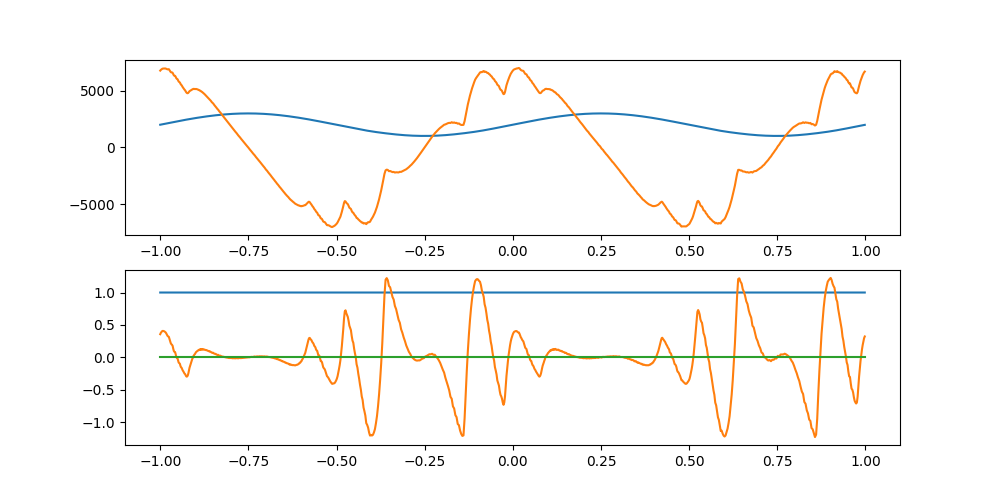

In [56]:

fig, axis = plt.subplots(2, 1, figsize = (10,5), squeeze = False)

axis[0,0].plot(perennialState['fluid']['positions'],b_scalar)
axis[0,0].plot(perennialState['fluid']['positions'],b_grad)

axis[1,0].plot(perennialState['fluid']['positions'],M_0)
axis[1,0].plot(perennialState['fluid']['positions'],M_grad)

axis[1,0].plot(perennialState['fluid']['positions'],M_x)

In [57]:
print(M_0.shape, M_x.shape)

torch.Size([1024]) torch.Size([1024, 1])


In [58]:
M = []

M.append(torch.cat([M_0.view(-1,1), M_x], dim = 1))
M.append(torch.cat([M_grad[:,0].view(-1,1), M_x_grad[:,:,0]], dim = 1))

for row in M:
    print(row.shape)

M = torch.stack(M, dim = 1)

print(M.shape)

b = torch.cat([b_scalar.view(-1,1), b_grad], dim = 1)
print(b.shape)

torch.Size([1024, 2])
torch.Size([1024, 2])
torch.Size([1024, 2, 2])
torch.Size([1024, 2])


In [60]:
solution = torch.linalg.solve(M, b)


dx = 0.1
extrapolation = solution[:,0] + dx * solution[:,1]

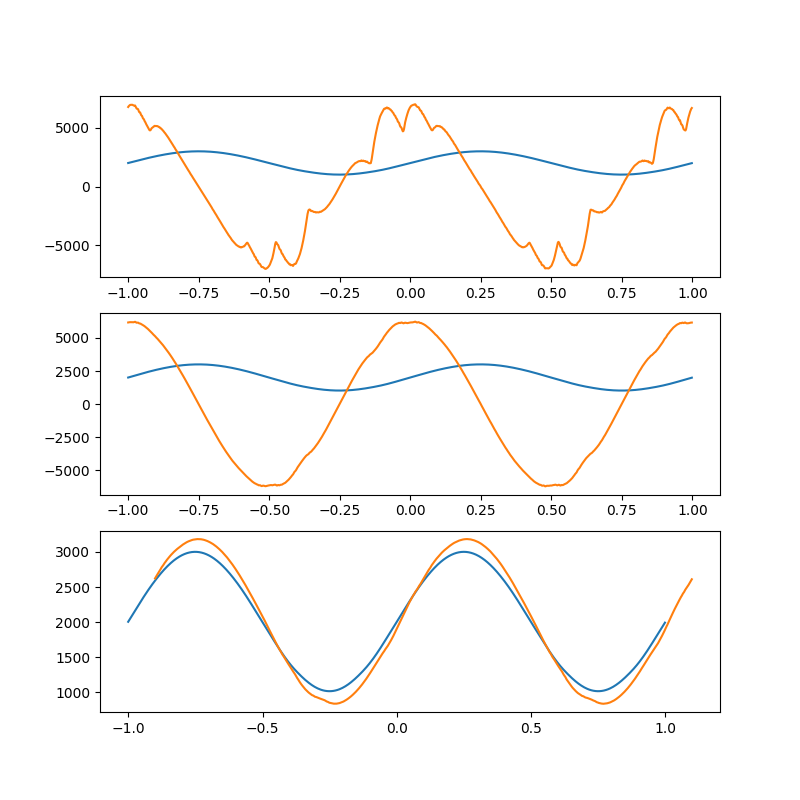

In [61]:

fig, axis = plt.subplots(3, 1, figsize = (8,8), squeeze = False)

axis[0,0].plot(perennialState['fluid']['positions'],b_scalar)
axis[0,0].plot(perennialState['fluid']['positions'],b_grad)

axis[1,0].plot(perennialState['fluid']['positions'],solution[:,0])
axis[1,0].plot(perennialState['fluid']['positions'],solution[:,1])

# axis[1,0].plot(perennialState['fluid']['positions'],M_x)


axis[2,0].plot(perennialState['fluid']['positions'],b_scalar)
axis[2,0].plot(perennialState['fluid']['positions'] + dx, extrapolation)
